# Exploratory analysis

TODO:
- URLs can be found elsewhere (e.g., biographies, names, etc.)
- Check line feed handling when creating dump
- Always keep an eye to the temporal dimension
- Why fake ORCID records are being created? [Link farming/SEO hacking, anything else?]
- Can we access private info thanks to the OpenAIRE ORCID membership? No.
- Check special cases of worksource as in https://orcid.org/0000-0002-4469-621X where "author name VIA ResearcherID"


In [25]:
import glob
import ast
import re

from datetime import datetime
import pytz

import tldextract

import ssl # needed because nltk.download down here fires an error
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import numpy as np
import pandas as pd

# import antispam
# import profanity_check

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.express as px

init_notebook_mode(connected=True)
TOP_N = 0
TOP_RANGE = [0, 0]

def set_top_n(n):
    global TOP_N, TOP_RANGE
    TOP_N = n
    TOP_RANGE = [-.5, n - 1 + .5]
    
pd.set_option('display.max_columns', None)

[nltk_data] Downloading package punkt to /Users/andrea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Notable solid ORCID iDs for explorative purposes:

In [26]:
AM = '0000-0002-5193-7851'
PP = '0000-0002-8588-4196'

Notable anomalies:

In [27]:
JOURNAL = '0000-0003-1815-5732'
NOINFO = '0000-0001-5009-2052'
VALID_NO_OA = '0000-0002-5154-6404' # True profile, but not in OpenAIRE
WORK_MISUSE = '0000-0001-7870-1120'
# todo: find group-shared ORCiD, if possible

Notable fake ORCID iDs:

In [28]:
FAKE_HEAP = {
    'scaffold': '0000-0001-5004-7761',
    'whatsapp': '0000-0001-6997-9470',
    'penis': '0000-0002-3399-7287',
    'bitcoin': '0000-0002-7518-6845',
    'fitness': '0000-0002-1234-835X',    # URL record + employment
    'cannabis': '0000-0002-9025-8632',   # URL > 70 + works (now REMOVED)
    'plumber': '0000-0002-1700-8311',    # URL > 10 + works
    'furniture': '0000-0001-7478-4539',
    'cleaners': '0000-0002-7392-3792',
    'toxiburn': '0000-0001-7505-2081',   # URLs in bio
    'ultraburst': '0000-0002-7037-3393', # URLs in bio
    'testoryze': '0000-0002-6361-8129',  # UNRL in bio
    'rlmax': '0000-0002-0393-7865',
    'eretrol': '0000-0002-6226-8905',
    'memomax': '0000-0002-2231-4233',
    'keto': '0000-0002-5521-9494',
    'baukredit': '0000-0002-5402-9920',
    'barber': '0000-0002-6766-8254'
}

Load the dataset

In [29]:
parts = glob.glob('../data/processed/dataset.pkl.*')

df = pd.concat((pd.read_pickle(part) for part in sorted(parts)))
df.head(5)

orcid  verified_email  verified_primary_email given_names  \
0  0000-0001-6097-3953           False                   False        <NA>   
1  0000-0001-6112-5550            True                    True        <NA>   
2  0000-0001-6152-2695            True                    True        <NA>   
3  0000-0001-7071-8294            True                    True        <NA>   
4  0000-0001-7247-6831            True                    True        <NA>   

  family_name biography                 other_names urls primary_email  \
0        <NA>      <NA>                         NaN  NaN          <NA>   
1        <NA>      <NA>  [v.i. yurtaev; v. yurtaev]  NaN          <NA>   
2        <NA>      <NA>                         NaN  NaN          <NA>   
3        <NA>      <NA>                         NaN  NaN          <NA>   
4        <NA>      <NA>                         NaN  NaN          <NA>   

  keywords external_ids education  \
0      NaN          NaN       NaN   
1      NaN          NaN       NaN   
2      NaN          NaN       NaN   
3      NaN          NaN       NaN   
4      NaN          NaN       NaN   

                                          employment  n_works works_source  \
0                                                NaN        0          NaN   
1  [[professor, peoples friendship university of ...        0          NaN   
2                                                NaN        0          NaN   
3  [[researcher (academic), universidad de zarago...        0          NaN   
4                                                NaN        0          NaN   

                   activation_date                 last_update_date  n_doi  \
0 2018-03-02 09:29:16.528000+00:00 2018-03-02 09:43:07.551000+00:00      0   
1 2018-04-03 07:50:23.358000+00:00 2020-03-18 09:42:44.753000+00:00      0   
2 2019-12-11 15:31:56.388000+00:00 2020-01-28 15:34:17.309000+00:00      0   
3 2014-03-10 13:22:01.966000+00:00 2016-06-14 22:17:54.470000+00:00      0   
4 2019-07-19 15:57:46.116000+00:00 2019-07-19 16:04:33.839000+00:00      0   

   n_arxiv  n_pmc  n_other_pids other_urls  label primary_email_domain  \
0        0      0             0        NaN  False                  NaN   
1        0      0             0        NaN  False                  NaN   
2        0      0             0        NaN  False                  NaN   
3        0      0             0        NaN  False                  NaN   
4        0      0             0        NaN  False                  NaN   

  other_email_domains url_domains other_url_domains  n_emails  n_urls  n_ids  \
0                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
1                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
2                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
3                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
4                 NaN         NaN               NaN      <NA>    <NA>   <NA>   

   n_keywords  n_education  n_employment  
0        <NA>         <NA>          <NA>  
1        <NA>         <NA>             1  
2        <NA>         <NA>          <NA>  
3        <NA>         <NA>             2  
4        <NA>         <NA>          <NA>

Notable records inspection

In [30]:
df[df['orcid'] == AM]

orcid  verified_email  verified_primary_email  \
6462863  0000-0002-5193-7851            True                    True   

        given_names family_name  \
6462863      andrea    mannocci   

                                                 biography other_names  \
6462863  data scientist & researcher; scholarly knowled...         NaN   

                                                      urls  \
6462863  [[personal website, https://andremann.github.i...   

                       primary_email  \
6462863  andrea.mannocci@isti.cnr.it   

                                                  keywords  \
6462863  [science of science, scholarly knowledge minin...   

                              external_ids  \
6462863  [[scopus author id, 55233589900]]   

                                                 education  \
6462863  [[information engineering, ph.d., università d...   

                                                employment  n_works  \
6462863  [[research associate, istituto di scienza e te...       37   

                                              works_source  \
6462863  [scopus - elsevier, crossref metadata search, ...   

                         activation_date                 last_update_date  \
6462863 2017-09-12 14:28:33.467000+00:00 2021-04-24 04:37:09.879000+00:00   

         n_doi  n_arxiv  n_pmc  n_other_pids other_urls  label  \
6462863     34        0      0            60        NaN   True   

        primary_email_domain other_email_domains  \
6462863          isti.cnr.it                 NaN   

                                               url_domains other_url_domains  \
6462863  {twitter.com, google.com, github.io, linkedin....               NaN   

         n_emails  n_urls  n_ids  n_keywords  n_education  n_employment  
6462863      <NA>       4      1           5            4             5

In [31]:
df[df['orcid'] == FAKE_HEAP['whatsapp']]

orcid  verified_email  verified_primary_email  \
10212327  0000-0001-6997-9470            True                    True   

         given_names family_name biography other_names  \
10212327       other    whatsapp      <NA>         NaN   

                                                       urls primary_email  \
10212327  [[otherwhatsapp, https://otherwhatsapp.com/], ...          <NA>   

                                                   keywords external_ids  \
10212327  [whatsapp gb, whatsapp gb apk, whatsapp gb 202...          NaN   

         education employment  n_works works_source  \
10212327       NaN        NaN        0          NaN   

                          activation_date                 last_update_date  \
10212327 2020-10-07 10:37:12.237000+00:00 2020-10-08 02:32:03.935000+00:00   

          n_doi  n_arxiv  n_pmc  n_other_pids other_urls  label  \
10212327      0        0      0             0        NaN  False   

         primary_email_domain other_email_domains  \
10212327                  NaN                 NaN   

                                                url_domains other_url_domains  \
10212327  {facebook.com, last.fm, vk.com, tumblr.com, yo...               NaN   

          n_emails  n_urls  n_ids  n_keywords  n_education  n_employment  
10212327      <NA>      27   <NA>           4         <NA>          <NA>

In [32]:
df.count()

orcid                     11349607
verified_email            11349607
verified_primary_email    11349607
given_names               11318228
family_name               11017320
biography                   376153
other_names                 568998
urls                        746443
primary_email               129037
keywords                    664556
external_ids               1335691
education                  2493817
employment                 2750231
n_works                   11349607
works_source               2830772
activation_date           11349607
last_update_date          11349607
n_doi                     11349607
n_arxiv                   11349607
n_pmc                     11349607
n_other_pids              11349607
other_urls                   15842
label                     11349607
primary_email_domain        129037
other_email_domains          50223
url_domains                 746443
other_url_domains            15842
n_emails                     50223
n_urls              

In [33]:
df['orcid'].describe()

count                11349607
unique               11349607
top       0000-0003-4828-3321
freq                        1
Name: orcid, dtype: object

In [34]:
df['primary_email'].describe()

count                     129037
unique                    129032
top       opercin@erbakan.edu.tr
freq                           2
Name: primary_email, dtype: object

Dupe emails

In [35]:
df['primary_email'].dropna().loc[df['primary_email'].duplicated()]

1734114       opercin@erbakan.edu.tr
7790373             maykin@owasp.org
10265986    garcialopezart@gmail.com
10706978       andycheng2026@163.com
11344431    patrick.davey@monash.edu
Name: primary_email, dtype: string

In [36]:
df[df['primary_email'] == 'maykin@owasp.org']

orcid  verified_email  verified_primary_email  \
4466844  0000-0001-9855-1676            True                    True   
7790373  0000-0002-0836-2271            True                    True   

        given_names family_name biography other_names urls     primary_email  \
4466844      maykin    warasart      <NA>         NaN  NaN  maykin@owasp.org   
7790373      maykin    warasart      <NA>         NaN  NaN  maykin@owasp.org   

        keywords external_ids education employment  n_works works_source  \
4466844      NaN          NaN       NaN        NaN        0          NaN   
7790373      NaN          NaN       NaN        NaN        0          NaN   

                         activation_date                 last_update_date  \
4466844 2020-10-23 17:51:51.925000+00:00 2021-03-26 08:27:30.509000+00:00   
7790373 2020-09-15 04:43:55.709000+00:00 2020-09-15 05:17:28.509000+00:00   

         n_doi  n_arxiv  n_pmc  n_other_pids other_urls  label  \
4466844      0        0      0             0        NaN  False   
7790373      0        0      0             0        NaN  False   

        primary_email_domain other_email_domains url_domains  \
4466844            owasp.org                 NaN         NaN   
7790373            owasp.org         [dga.or.th]         NaN   

        other_url_domains  n_emails  n_urls  n_ids  n_keywords  n_education  \
4466844               NaN      <NA>    <NA>   <NA>        <NA>         <NA>   
7790373               NaN         1    <NA>   <NA>        <NA>         <NA>   

         n_employment  
4466844          <NA>  
7790373          <NA>

In [37]:
df[df['primary_email'] == 'opercin@erbakan.edu.tr']

orcid  verified_email  verified_primary_email  \
358094   0000-0002-2232-9638            True                    True   
1734114  0000-0003-0033-0918            True                    True   

        given_names family_name biography other_names urls  \
358094        osman      perçin      <NA>         NaN  NaN   
1734114       osman      perçin      <NA>         NaN  NaN   

                  primary_email keywords external_ids education  \
358094   opercin@erbakan.edu.tr      NaN          NaN       NaN   
1734114  opercin@erbakan.edu.tr      NaN          NaN       NaN   

                                                employment  n_works  \
358094                                                 NaN        0   
1734114  [[, necmettin erbakan university, konya, , tr,...        0   

        works_source                  activation_date  \
358094           NaN 2015-01-12 13:47:55.549000+00:00   
1734114          NaN 2015-10-13 05:47:12.014000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
358094  2020-01-27 07:38:24.269000+00:00      0        0      0             0   
1734114 2020-12-25 13:52:03.976000+00:00      0        0      0             0   

        other_urls  label primary_email_domain other_email_domains  \
358094         NaN  False       erbakan.edu.tr                 NaN   
1734114        NaN  False       erbakan.edu.tr                 NaN   

        url_domains other_url_domains  n_emails  n_urls  n_ids  n_keywords  \
358094          NaN               NaN      <NA>    <NA>   <NA>        <NA>   
1734114         NaN               NaN      <NA>    <NA>   <NA>        <NA>   

         n_education  n_employment  
358094          <NA>          <NA>  
1734114         <NA>             1

In [38]:
df[df['primary_email'] == 'patrick.davey@monash.edu']

orcid  verified_email  verified_primary_email  \
983898    0000-0002-9158-1757            True                    True   
11344431  0000-0002-8774-0030            True                    True   

         given_names family_name biography other_names urls  \
983898       patrick       davey      <NA>         NaN  NaN   
11344431     patrick       davey      <NA>         NaN  NaN   

                     primary_email  \
983898    patrick.davey@monash.edu   
11344431  patrick.davey@monash.edu   

                                                   keywords external_ids  \
983898    [inorganic chemistry, radiochemistry, radiopha...          NaN   
11344431                                                NaN          NaN   

         education                                         employment  \
983898         NaN  [[phd student, monash university, melbourne, ,...   
11344431       NaN  [[phd student, monash university, melbourne, v...   

          n_works works_source                  activation_date  \
983898          0          NaN 2019-05-09 23:01:02.170000+00:00   
11344431        1   [crossref] 2018-09-11 10:47:10.997000+00:00   

                         last_update_date  n_doi  n_arxiv  n_pmc  \
983898   2019-08-20 03:00:17.844000+00:00      0        0      0   
11344431 2021-04-30 05:47:48.213000+00:00      1        0      0   

          n_other_pids other_urls  label primary_email_domain  \
983898               0        NaN  False           monash.edu   
11344431             0        NaN   True           monash.edu   

         other_email_domains url_domains other_url_domains  n_emails  n_urls  \
983898                   NaN         NaN               NaN      <NA>    <NA>   
11344431                 NaN         NaN               NaN      <NA>    <NA>   

          n_ids  n_keywords  n_education  n_employment  
983898     <NA>           4         <NA>             1  
11344431   <NA>        <NA>         <NA>             1

In [39]:
df['primary_email_domain'].describe()

count        129037
unique        17499
top       gmail.com
freq          27831
Name: primary_email_domain, dtype: object

In [40]:
top_primary_emails = df[['primary_email_domain', 'orcid']]\
                .groupby('primary_email_domain')\
                .count()\
                .sort_values('orcid', ascending=False)

In [41]:
set_top_n(30)
data = [
    go.Bar(
        x=top_primary_emails[:TOP_N].index,
        y=top_primary_emails[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s email domains' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

This somehow makes sense, legitimate users could put the gmail account as primary for login purposes and have institutional addresses as other email addresses. It makes also the life easier upon relocation.

## Other emails

In [42]:
df['other_email_domains'].describe()

count           50223
unique          16012
top       [gmail.com]
freq             9331
Name: other_email_domains, dtype: object

In [43]:
emails_by_orcid = df[['orcid', 'n_emails']].sort_values('n_emails', ascending=False)

In [44]:
set_top_n(30)
data = [
    go.Bar(
        x=emails_by_orcid[:TOP_N]['orcid'],
        y=emails_by_orcid[:TOP_N]['n_emails']
    )
]

layout = go.Layout(
    title='Top %s ORCID iDs by email' % TOP_N, 
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [45]:
top_other_emails = df[['orcid', 'other_email_domains']]\
                        .explode('other_email_domains')\
                        .reset_index(drop=True)\
                        .groupby('other_email_domains')\
                        .count()\
                        .sort_values('orcid', ascending=False)

In [46]:
set_top_n(30)
data = [
    go.Bar(
        x=top_other_emails[:TOP_N].index,
        y=top_other_emails[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top %s other email domains' % TOP_N, 
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

## URLs

In [47]:
df.n_urls.describe()

count    746443.000000
mean          1.368308
std           1.224000
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         193.000000
Name: n_urls, dtype: float64

In [48]:
df[df.n_urls > df.n_urls.max()]

Empty DataFrame
Columns: [orcid, verified_email, verified_primary_email, given_names, family_name, biography, other_names, urls, primary_email, keywords, external_ids, education, employment, n_works, works_source, activation_date, last_update_date, n_doi, n_arxiv, n_pmc, n_other_pids, other_urls, label, primary_email_domain, other_email_domains, url_domains, other_url_domains, n_emails, n_urls, n_ids, n_keywords, n_education, n_employment]
Index: []

In [49]:
df[df.url_domains.notna()].head()

orcid  verified_email  verified_primary_email  \
5    0000-0001-7402-0096            True                    True   
10   0000-0001-8377-3508            True                    True   
26   0000-0002-2638-4108            True                    True   
151  0000-0003-1284-9741            True                    True   
171  0000-0001-7324-3247            True                    True   

            given_names       family_name  \
5                  <NA>              <NA>   
10                 <NA>              <NA>   
26                 <NA>              <NA>   
151  alex percy antonio  manriquez paisig   
171              amable     lopez piñeiro   

                                             biography  \
5                                                 <NA>   
10                                                <NA>   
26   investigador de la universidad de oviedo. depa...   
151                                               <NA>   
171                                               <NA>   

                    other_names  \
5                           NaN   
10   [fontana, milena da silva]   
26                          NaN   
151                         NaN   
171                         NaN   

                                                  urls primary_email  \
5    [[kth profile, https://www.kth.se/profile/toma...          <NA>   
10   [[currículo lattes, http://buscatextual.cnpq.b...          <NA>   
26   [[cv ignacio fernandez sarasola, https://www.u...          <NA>   
151  [[canal de youtube, https://www.youtube.com/ch...          <NA>   
171  [[web de la universidad politécnica de madrid ...          <NA>   

                                              keywords  \
5                                                  NaN   
10                [educação; informática; matemática.]   
26   [constitutional history, constitutional law, h...   
151                                                NaN   
171                                                NaN   

                          external_ids  \
5                                  NaN   
10                                 NaN   
26   [[scopus author id, 54394231000]]   
151                                NaN   
171                                NaN   

                                             education  \
5                                                  NaN   
10                                                 NaN   
26   [[public law, ph doctor, university of oviedo,...   
151                                                NaN   
171                                                NaN   

                                            employment  n_works works_source  \
5    [[, kth royal institute of technology, stockho...        0          NaN   
10   [[, instituto federal de educação, ciência e t...        0          NaN   
26   [[professor of constitutional law, university ...        1   [crossref]   
151                                                NaN        0          NaN   
171  [[, universidad politécnica de madrid - techni...        0          NaN   

                     activation_date                 last_update_date  n_doi  \
5   2015-01-11 15:13:06.467000+00:00 2016-06-14 23:55:59.896000+00:00      0   
10  2018-05-23 23:39:04.534000+00:00 2019-10-16 02:50:11.007000+00:00      0   
26  2013-03-25 14:38:06.016000+00:00 2020-07-01 13:10:37.025000+00:00      1   
151 2020-09-08 20:04:33.906000+00:00 2020-09-08 20:25:55.432000+00:00      0   
171 2014-12-19 11:48:29.669000+00:00 2019-12-09 18:48:42.579000+00:00      0   

     n_arxiv  n_pmc  n_other_pids other_urls  label primary_email_domain  \
5          0      0             0        NaN  False                  NaN   
10         0      0             0        NaN  False                  NaN   
26         0      0             0        NaN  False                  NaN   
151        0      0             0        NaN  False                  NaN   
171        0      0             0        NaN  False  

In [50]:
urls_by_orcid = df[['orcid', 'n_urls']].sort_values('n_urls', ascending=False)
urls_by_orcid

orcid  n_urls
3326559   0000-0002-1234-835X     193
4341400   0000-0001-7478-4539     168
5061057   0000-0002-7392-3792     152
8453449   0000-0002-6938-9638     148
1743760   0000-0001-5384-0001     104
...                       ...     ...
11349602  0000-0002-1686-1935    <NA>
11349603  0000-0002-3800-6331    <NA>
11349604  0000-0002-8783-5814    <NA>
11349605  0000-0002-7584-2283    <NA>
11349606  0000-0003-0529-3538    <NA>

[11349607 rows x 2 columns]

The first three are fake, the fourth isn't. No assumption can be taken.

In [51]:
set_top_n(100)
data = [
    go.Bar(
        x=urls_by_orcid[:TOP_N]['orcid'],
        y=urls_by_orcid[:TOP_N]['n_urls']
    )
]

layout = go.Layout(
    title='Top %s ORCID iDs with URLs' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [52]:
top_urls = df[['orcid', 'url_domains']]\
                .explode('url_domains')\
                .reset_index(drop=True)\
                .groupby('url_domains')\
                .count()\
                .sort_values('orcid', ascending=False)

In [53]:
set_top_n(50)
data = [
    go.Bar(
        x=top_urls[:TOP_N].index,
        y=top_urls[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s URL domains' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

Malformed URLs are left empty

In [54]:
exploded_url_domains = df[['orcid', 'url_domains']].explode('url_domains')

In [55]:
exploded_url_domains[exploded_url_domains.url_domains == ''].count()

orcid          71
url_domains    71
dtype: int64

### Academic URL filtering according to GRID.ac

In [56]:
def extract_domain(link):
    return tldextract.extract(link).registered_domain

In [57]:
grid_df = pd.read_csv('../data/external/grid/full_tables/links.csv', index_col='grid_id')
grid_df['domain'] = grid_df.link.apply(extract_domain)

In [58]:
grid_df

link             domain
grid_id                                                         
grid.1001.0            http://www.anu.edu.au/         anu.edu.au
grid.1002.3            http://www.monash.edu/         monash.edu
grid.1003.2             http://www.uq.edu.au/          uq.edu.au
grid.1004.5                 http://mq.edu.au/          mq.edu.au
grid.1005.4          https://www.unsw.edu.au/        unsw.edu.au
...                                       ...                ...
grid.510886.2              https://cftni.org/          cftni.org
grid.510887.3       https://tinybeamfund.org/   tinybeamfund.org
grid.510888.c  https://www.tmg-thinktank.com/  tmg-thinktank.com
grid.510889.d      https://www.unicef.org/eap         unicef.org
grid.510890.5     https://www.whitehouse.gov/     whitehouse.gov

[98933 rows x 2 columns]

In [59]:
grid_df.loc['grid.451498.5']

link      http://www.isti.cnr.it/
domain                     cnr.it
Name: grid.451498.5, dtype: object

In [60]:
exp = df[['orcid', 'url_domains']].explode('url_domains')
exp = exp[exp.url_domains.notna()]
exp

orcid      url_domains
5         0000-0001-7402-0096           kth.se
10        0000-0001-8377-3508          cnpq.br
26        0000-0002-2638-4108     unioviedo.es
151       0000-0003-1284-9741      youtube.com
171       0000-0001-7324-3247           upm.es
...                       ...              ...
11349589  0000-0002-5204-5302       apetau.com
11349589  0000-0002-5204-5302     facebook.com
11349597  0000-0002-2906-0299  oxytocin.com.au
11349597  0000-0002-2906-0299     linkedin.com
11349599  0000-0002-1070-2220   vpsantanna.com

[1021364 rows x 2 columns]

In [61]:
exp['grid'] = exp.url_domains.isin(grid_df.domain)

In [62]:
non_grid_domains = exp[~exp.url_domains.isin(grid_df.domain)].groupby('url_domains').count().sort_values('orcid', ascending=False)

In [63]:
DOMAIN_EXCLUSIONS = ['google.', 'youtube.', 'github', 'researchgate', 'academia.edu', 'elsevier.', 'elsevierpure.com',
                    'publons.', 'scopus', 'researcherid', 'ac.uk', '.gov.', '.edu', 'arxiv']
for dex in DOMAIN_EXCLUSIONS:
    non_grid_domains.drop(non_grid_domains.filter(like=dex, axis=0).index, inplace=True)

In [64]:
non_grid_domains.to_csv('../data/processed/non_grid_urls.csv')

### URLs present in other parts of the ORCID records

In [65]:
df[df.other_urls.str.len() > 0][['orcid', 'urls', 'other_urls']]

orcid  \
593       0000-0002-0316-839X   
1078      0000-0002-5231-666X   
1111      0000-0001-5067-2321   
5636      0000-0002-1080-7903   
5947      0000-0001-7259-8038   
...                       ...   
11344576  0000-0002-8883-1217   
11345866  0000-0002-7597-9511   
11346317  0000-0002-0201-1163   
11347666  0000-0002-8506-4323   
11348851  0000-0001-7432-5404   

                                                       urls  \
593                                                     NaN   
1078                                                    NaN   
1111                                                    NaN   
5636      [[, https://www.beautybydrcat.com/body-plastic...   
5947                                                    NaN   
...                                                     ...   
11344576                                                NaN   
11345866                                                NaN   
11346317                                                NaN   
11347666  [[du an empire city, https://salereal.com.vn/c...   
11348851  [[queen mary university of london staff page, ...   

                                                 other_urls  
593       [http://www.dukagjinicollege.eu/libri3/001, ht...  
1078                  [http://www.pythagoreanuniverse.com/]  
1111      [https://doi.org/10.1155/2017/2170816.2., http...  
5636      [https://www.beautybydrcat.com/about-surgery-p...  
5947                  [http://www.linkedin.com/in/edrovera]  
...                                                     ...  
11344576                             [https://aaerc.com.au]  
11345866                       [https://videos.arynews.tv/]  
11346317  [https://g.page/non-surgical-body-contouring-n...  
11347666      [https://trandinhhieu.com/du-an/empire-city/]  
11348851  [https://peoplespalaceprojects.org.uk/en/proje...  

[15842 rows x 3 columns]

In [66]:
df[(df.other_urls.str.len() > 0) & (df.urls.isna())][['orcid', 'urls', 'other_urls']]

orcid urls  \
593       0000-0002-0316-839X  NaN   
1078      0000-0002-5231-666X  NaN   
1111      0000-0001-5067-2321  NaN   
5947      0000-0001-7259-8038  NaN   
7227      0000-0001-8381-4891  NaN   
...                       ...  ...   
11343402  0000-0003-1551-4613  NaN   
11344192  0000-0002-1070-2976  NaN   
11344576  0000-0002-8883-1217  NaN   
11345866  0000-0002-7597-9511  NaN   
11346317  0000-0002-0201-1163  NaN   

                                                 other_urls  
593       [http://www.dukagjinicollege.eu/libri3/001, ht...  
1078                  [http://www.pythagoreanuniverse.com/]  
1111      [https://doi.org/10.1155/2017/2170816.2., http...  
5947                  [http://www.linkedin.com/in/edrovera]  
7227              [https://www.fontussciences.com/lozenges]  
...                                                     ...  
11343402  [http://2016.ifmbe.org/),, http://www.bd2decid...  
11344192           [http://lattes.cnpq.br/0219822413040642]  
11344576                             [https://aaerc.com.au]  
11345866                       [https://videos.arynews.tv/]  
11346317  [https://g.page/non-surgical-body-contouring-n...  

[9413 rows x 3 columns]

## Works source

In [67]:
def remove_self_source(lst, given, family):
    res = []
    for ws in lst:
        if ws.lower().find(given.lower()) == -1:
            if pd.notna(family):
                if ws.lower().find(family.lower()) == -1:
                    res.append(ws)
            else:
                res.append(ws)
    return res

In [68]:
df['ext_works_source'] = df[(df.works_source.notna()) & (df.given_names.notna())]\
                        .apply(lambda x: remove_self_source(x['works_source'], x['given_names'], x['family_name']), axis=1)

In [69]:
df['n_ext_work_source'] = pd.Series(df.ext_works_source.str.len(), dtype=pd.Int16Dtype())

In [70]:
exploded_external_sources = df[df['ext_works_source'].str.len() > 0][['orcid','ext_works_source']]\
                            .explode('ext_works_source').reset_index(drop=True)

In [71]:
grouped_ext_sources = exploded_external_sources.groupby('ext_works_source')\
                        .count()\
                        .sort_values('orcid', ascending=False)\
                        .reset_index()

In [72]:
set_top_n(30)
data = [
    go.Bar(
        x=grouped_ext_sources[:TOP_N].ext_works_source,
        y=grouped_ext_sources[:TOP_N].orcid
    )
]

layout = go.Layout(
    title='Top %s works_source' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [73]:
authoritative_sources = grouped_ext_sources[grouped_ext_sources['orcid'] > 2]
authoritative_sources

ext_works_source    orcid
0                                          crossref  1526827
1                                 scopus - elsevier   925561
2                          crossref metadata search   303924
3    multidisciplinary digital publishing institute   302224
4                             europe pubmed central   185098
..                                              ...      ...
348                         smithsonian institution        3
349                universitätsbibliothek paderborn        3
350                 uta - oa journal global insight        3
351     uc viden - university college south denmark        3
352                                           silva        3

[353 rows x 2 columns]

In [74]:
exploded_external_sources['authoritative'] = exploded_external_sources.ext_works_source\
                                            .isin(authoritative_sources['ext_works_source'])

In [75]:
orcid_authoritative_source = exploded_external_sources\
                            .groupby('orcid')['authoritative']\
                            .any()\
                            .reset_index()[['orcid', 'authoritative']]

In [76]:
df = df.merge(orcid_authoritative_source, on='orcid', how='left')

In [77]:
df.loc[df.authoritative.isna(), 'authoritative'] = False

In [78]:
df.head()

orcid  verified_email  verified_primary_email given_names  \
0  0000-0001-6097-3953           False                   False        <NA>   
1  0000-0001-6112-5550            True                    True        <NA>   
2  0000-0001-6152-2695            True                    True        <NA>   
3  0000-0001-7071-8294            True                    True        <NA>   
4  0000-0001-7247-6831            True                    True        <NA>   

  family_name biography                 other_names urls primary_email  \
0        <NA>      <NA>                         NaN  NaN          <NA>   
1        <NA>      <NA>  [v.i. yurtaev; v. yurtaev]  NaN          <NA>   
2        <NA>      <NA>                         NaN  NaN          <NA>   
3        <NA>      <NA>                         NaN  NaN          <NA>   
4        <NA>      <NA>                         NaN  NaN          <NA>   

  keywords external_ids education  \
0      NaN          NaN       NaN   
1      NaN          NaN       NaN   
2      NaN          NaN       NaN   
3      NaN          NaN       NaN   
4      NaN          NaN       NaN   

                                          employment  n_works works_source  \
0                                                NaN        0          NaN   
1  [[professor, peoples friendship university of ...        0          NaN   
2                                                NaN        0          NaN   
3  [[researcher (academic), universidad de zarago...        0          NaN   
4                                                NaN        0          NaN   

                   activation_date                 last_update_date  n_doi  \
0 2018-03-02 09:29:16.528000+00:00 2018-03-02 09:43:07.551000+00:00      0   
1 2018-04-03 07:50:23.358000+00:00 2020-03-18 09:42:44.753000+00:00      0   
2 2019-12-11 15:31:56.388000+00:00 2020-01-28 15:34:17.309000+00:00      0   
3 2014-03-10 13:22:01.966000+00:00 2016-06-14 22:17:54.470000+00:00      0   
4 2019-07-19 15:57:46.116000+00:00 2019-07-19 16:04:33.839000+00:00      0   

   n_arxiv  n_pmc  n_other_pids other_urls  label primary_email_domain  \
0        0      0             0        NaN  False                  NaN   
1        0      0             0        NaN  False                  NaN   
2        0      0             0        NaN  False                  NaN   
3        0      0             0        NaN  False                  NaN   
4        0      0             0        NaN  False                  NaN   

  other_email_domains url_domains other_url_domains  n_emails  n_urls  n_ids  \
0                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
1                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
2                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
3                 NaN         NaN               NaN      <NA>    <NA>   <NA>   
4                 NaN         NaN               NaN      <NA>    <NA>   <NA>   

   n_keywords  n_education  n_employment ext_works_source  n_ext_work_source  \
0        <NA>         <NA>          <NA>              NaN               <NA>   
1        <NA>         <NA>             1              NaN               <NA>   
2        <NA>         <NA>          <NA>              NaN               <NA>   
3        <NA>         <NA>             2              NaN               <NA>   
4        <NA>         <NA>          <NA>              NaN               <NA>   

  authoritative  
0         False  
1         False  
2         False  
3         False  
4         False

## External IDs

External IDs should come from reliable sources. ORCiD registrants cannot add them freely.

In [79]:
df.n_ids.describe()

count    1.335691e+06
mean     1.360596e+00
std      6.673242e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.000000e+01
Name: n_ids, dtype: float64

In [80]:
df[df.n_ids == df.n_ids.max()]

orcid  verified_email  verified_primary_email  \
2145720  0000-0002-9554-6633            True                    True   

        given_names family_name biography other_names  \
2145720      john a    williams      <NA>         NaN   

                                                      urls primary_email  \
2145720  [[aston university profile page, https://resea...          <NA>   

        keywords                                       external_ids education  \
2145720      NaN  [[scopus author id,  55553733518], [scopus aut...       NaN   

                                                employment  n_works  \
2145720  [[, aston university, birmingham, , gb, 1722, ...       92   

                      works_source                  activation_date  \
2145720  [aston research explorer] 2014-11-20 09:42:10.690000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
2145720 2021-04-08 00:00:40.672000+00:00     80        0      0           209   

        other_urls  label primary_email_domain other_email_domains  \
2145720        NaN   True                  NaN                 NaN   

           url_domains other_url_domains  n_emails  n_urls  n_ids  n_keywords  \
2145720  {aston.ac.uk}               NaN      <NA>       1     80        <NA>   

         n_education  n_employment           ext_works_source  \
2145720         <NA>             1  [aston research explorer]   

         n_ext_work_source authoritative  
2145720                  1          True

In [81]:
ids = df[['orcid', 'external_ids']].explode('external_ids').reset_index(drop=True)

In [82]:
ids['provider'] = ids[ids.external_ids.notna()]['external_ids'].apply(lambda x: x[0])

In [83]:
ids[ids.provider.notna()].head()

orcid                     external_ids          provider
8   0000-0001-8315-2066      [researcherid, k-4630-2014]      researcherid
26  0000-0002-2638-4108  [scopus author id, 54394231000]  scopus author id
45  0000-0003-2259-7023  [scopus author id, 57189297461]  scopus author id
59  0000-0002-7397-5824   [scopus author id, 8399842800]  scopus author id
68  0000-0002-0427-9745      [researcherid, b-5471-2018]      researcherid

In [84]:
top_ids_providers = ids.groupby('provider').count().sort_values('orcid', ascending=False)

In [85]:
data = [
    go.Bar(
        x=top_ids_providers.index,
        y=top_ids_providers['orcid']
    )
]

layout = go.Layout(
    title='IDs provided by providers',
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [86]:
pd.unique(ids['provider'])

array([nan, 'researcherid', 'scopus author id', 'loop profile', 'gnd',
       'ciência id', 'researcher name resolver id', 'pitt id',
       'id dialnet', 'isni', 'technical university of denmark cwis',
       'chalmers id', 'scopus author id: ', 'scopus author id:',
       'hkust profile', 'hku researcherpage', '中国科学家在线', 'uow scholars',
       'sciprofile', 'cti vitae', 'researcher id', 'digital author id',
       'researcherid:', 'authenticus', 'authenticusid', 'scopus  id',
       'sciprofiles', 'vivo cornell', 'authid', 'digital author id (dai)',
       'us epa vivo', 'github', 'dai', 'escientist',
       'smithsonian profiles', 'orcid id', 'iauthor', 'scopus id',
       'google scholar', 'kaken', 'dialnet id', 'researcherid: ',
       'une researcher id', 'id dialnet:', 'scienceopen', 'orcid',
       'profile system identifier', 'custom'], dtype=object)

## Keywords

This field is problematic as users can be nasty and put multiple keywords in one as opposed of having different keywords. Look this

In [87]:
keywords_by_orcid = df[['orcid', 'n_keywords']].sort_values('n_keywords', ascending=False)
keywords_by_orcid

orcid  n_keywords
3873190   0000-0002-0673-0341         154
8982683   0000-0003-3343-5660         148
5494950   0000-0002-6075-3501         140
6724874   0000-0002-7060-4112         140
1562610   0000-0001-5287-1949         132
...                       ...         ...
11349602  0000-0002-1686-1935        <NA>
11349603  0000-0002-3800-6331        <NA>
11349604  0000-0002-8783-5814        <NA>
11349605  0000-0002-7584-2283        <NA>
11349606  0000-0003-0529-3538        <NA>

[11349607 rows x 2 columns]

In [88]:
set_top_n(100)
data = [
    go.Bar(
        x=keywords_by_orcid[:TOP_N]['orcid'],
        y=keywords_by_orcid[:TOP_N]['n_keywords']
    )
]

layout = go.Layout(
    title='Keywords provided by ORCiD',
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [89]:
top_keywords = df[['orcid', 'keywords']]\
                .explode('keywords')\
                .reset_index(drop=True)\
                .groupby('keywords')\
                .count()\
                .sort_values('orcid', ascending=False)

In [90]:
set_top_n(50)
data = [
    go.Bar(
        x=top_keywords[:TOP_N].index,
        y=top_keywords[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s keywords occurrence' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

## Education

In [91]:
df.n_education.describe()

count    2.493817e+06
mean     1.816203e+00
std      1.134214e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.190000e+02
Name: n_education, dtype: float64

In [92]:
df[df.n_education == df.n_education.max()]

orcid  verified_email  verified_primary_email  \
3171493  0000-0002-1927-0292            True                    True   

           given_names     family_name  \
3171493  phd. carmen m  galvez-sánchez   

                                                 biography other_names urls  \
3171493  my name is carmen maria galvez sánchez. i´m a ...         NaN  NaN   

        primary_email                                           keywords  \
3171493          <NA>  [chronic pain, gender-based violence, qualitat...   

                                              external_ids  \
3171493  [[loop profile, 509331], [scopus author id, 57...   

                                                 education  \
3171493  [[psychology, 2019-2020 course. degree in psyc...   

                                                employment  n_works  \
3171493  [[research technician, fundación pública andal...       35   

                                              works_source  \
3171493  [phd. carmen m galvez-sánchez, multidisciplina...   

                         activation_date                 last_update_date  \
3171493 2016-04-18 14:28:57.237000+00:00 2021-04-25 18:24:06.260000+00:00   

         n_doi  n_arxiv  n_pmc  n_other_pids other_urls  label  \
3171493     24        0      0             7        NaN   True   

        primary_email_domain other_email_domains url_domains  \
3171493                  NaN                 NaN         NaN   

        other_url_domains  n_emails  n_urls  n_ids  n_keywords  n_education  \
3171493               NaN      <NA>    <NA>      2           5          219   

         n_employment                                   ext_works_source  \
3171493             4  [multidisciplinary digital publishing institut...   

         n_ext_work_source authoritative  
3171493                  4          True

In [93]:
exploded_education = df[['orcid', 'education']].explode('education').dropna()
exploded_education

orcid  \
25        0000-0002-2343-910X   
25        0000-0002-2343-910X   
25        0000-0002-2343-910X   
26        0000-0002-2638-4108   
47        0000-0003-2513-9984   
...                       ...   
11349602  0000-0002-1686-1935   
11349603  0000-0002-3800-6331   
11349603  0000-0002-3800-6331   
11349605  0000-0002-7584-2283   
11349605  0000-0002-7584-2283   

                                                  education  
25        [aeronautics and astronautics, phd, massachuse...  
25        [aeronautics and astronautics, sm, massachuset...  
25        [mechanical engineering and material science, ...  
26        [public law, ph doctor, university of oviedo, ...  
47        [medicine and surgery, student, cairo universi...  
...                                                     ...  
11349602  [, , south china agricultural university, guan...  
11349603  [richard gilder graduate school, phd in compar...  
11349603  [geological sciences and history (dual major),...  
11349605  [school of electronics and information, master...  
11349605  [ department of electrical engineering, bachel...  

[4529278 rows x 2 columns]

In [94]:
exploded_education[['department', 'degree', 'university', 'city', 'region', 'country', 'id', 'id_scheme']] = pd.DataFrame(exploded_education.education.tolist(), index=exploded_education.index)

In [95]:
exploded_education.id.replace('', pd.NA, inplace=True)

In [96]:
# exploded_education.groupby('orcid').id.count().reset_index()

In [97]:
df = df.merge(exploded_education.groupby('orcid').id.count().reset_index(), on='orcid', how='left')
df.rename(columns={'id': 'n_valid_education'}, inplace=True)

In [98]:
df[df.n_education != df.n_valid_education]

orcid  verified_email  verified_primary_email  \
68        0000-0002-0427-9745            True                    True   
82        0000-0002-3380-6671            True                    True   
91        0000-0001-6902-6549            True                    True   
94        0000-0002-6142-6406            True                    True   
167       0000-0002-0923-8176            True                    True   
...                       ...             ...                     ...   
11349563  0000-0002-1842-4130            True                    True   
11349569  0000-0003-0459-4822            True                    True   
11349571  0000-0003-0057-1551            True                    True   
11349585  0000-0003-4653-4705            True                    True   
11349602  0000-0002-1686-1935            True                    True   

            given_names          family_name  \
68               a. can                 inci   
82                abdul            asis pata   
91             abubakar             muhammad   
94                 adam              mamadou   
167        alicia alelí  chaparro caso-lópez   
...                 ...                  ...   
11349563  josé de jesús     cázares-marinero   
11349569          luana                 <NA>   
11349571       lyudmyla            antypenko   
11349585       patricia             teixeira   
11349602         youxia                 wang   

                                                  biography  \
68        i am a professor of finance at bryant universi...   
82                                                     <NA>   
91                                                     <NA>   
94                                                     <NA>   
167                                                    <NA>   
...                                                     ...   
11349563                                               <NA>   
11349569  mestranda em tecnologia na saúde e foi aluna o...   
11349571  the phd degree of pharmacy was received under ...   
11349585  2005 - phd, university of coimbra july 2009-ju...   
11349602  youxia wang (1995-), native of zunyi, guizhou ...   

                                                other_names  \
68                                                      NaN   
82                                                      NaN   
91                                                      NaN   
94                                                      NaN   
167                                    [alicia a. chaparro]   
...                                                     ...   
11349563                                     [josé cázares]   
11349569                               [luana bastos morey]   
11349571  [lyudmila nikolaevna antipenko (russian transl...   
11349585                                                NaN   
11349602                                                NaN   

                                                       urls primary_email  \
68                                                      NaN          <NA>   
82                                                      NaN          <NA>   
91                                                      NaN          <NA>   
94                                                      NaN          <NA>   
167                                                     NaN          <NA>   
...                                                     ...           ...   
11349563  [[linkedin, https://www.linkedin.com/feed/], [...          <NA>   
11349569  [[site da equipe unidos pela saúde  (voluntári...          <NA>   
11349571                                                NaN          <NA>   
11349585                                                NaN          <NA>   
11349602                                                NaN          <NA>   

                                                   keywords  \
68                                                      NaN   
82   

## Employment

In [99]:
df.n_employment.describe()

count    2.750231e+06
mean     1.666351e+00
std      1.537579e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.980000e+02
Name: n_employment, dtype: float64

In [100]:
df[df.n_employment == df.n_employment.max()]

orcid  verified_email  verified_primary_email  \
5725751  0000-0002-0293-964X            True                    True   

        given_names family_name biography other_names  \
5725751   ben zhong        tang      <NA>       [唐本忠]   

                                                 urls    primary_email  \
5725751  [[homepage, http://ihome.ust.hk/~tangbenz/]]  tangbenz@ust.hk   

                                                  keywords  \
5725751  [light-emitting molecules, hyperbranched polym...   

                                              external_ids  \
5725751  [[hkust profile, tang-benzhong], [researcherid...   

                                                 education  \
5725751  [[department of chemistry and faculty of pharm...   

                                                employment  n_works  \
5725751  [[chair professor, division of biomedical engi...      435   

                       works_source                  activation_date  \
5725751  [tang, benzhong, crossref] 2015-03-13 00:28:33.270000+00:00   

                        last_update_date  n_doi  n_arxiv  n_pmc  n_other_pids  \
5725751 2021-05-03 16:55:47.245000+00:00    372        0      0             0   

        other_urls  label primary_email_domain other_email_domains  \
5725751        NaN  False               ust.hk                 NaN   

        url_domains other_url_domains  n_emails  n_urls  n_ids  n_keywords  \
5725751    {ust.hk}               NaN      <NA>       1      3           7   

         n_education  n_employment ext_works_source  n_ext_work_source  \
5725751            7           198       [crossref]                  1   

        authoritative  n_valid_education  
5725751          True                3.0

Let's count how many employments have a valid assigned id by orcid (ringols, isni, grid, etc.)

In [101]:
exploded_employment = df[['orcid', 'employment']].explode('employment').dropna()
exploded_employment

orcid  \
1         0000-0001-6112-5550   
3         0000-0001-7071-8294   
3         0000-0001-7071-8294   
5         0000-0001-7402-0096   
8         0000-0001-8315-2066   
...                       ...   
11349601  0000-0003-2606-0936   
11349602  0000-0002-1686-1935   
11349603  0000-0002-3800-6331   
11349603  0000-0002-3800-6331   
11349605  0000-0002-7584-2283   

                                                 employment  
1         [professor, peoples friendship university of r...  
3         [researcher (academic), universidad de zaragoz...  
3         [researcher (academic), instituto de síntesis ...  
5         [, kth royal institute of technology, stockhol...  
8         [, universidad de córdoba, córdoba, andalucía,...  
...                                                     ...  
11349601  [post-doc, institute of biochemistry and cell ...  
11349602  [master, sichuan agricultural university , che...  
11349603  [assistant professor, baruch college, city uni...  
11349603  [postdoctoral scholar, university of californi...  
11349605  [lecturer, henan institute of science and tech...  

[4582849 rows x 2 columns]

In [102]:
exploded_employment[['role', 'institution', 'city', 'region', 'country', 'id', 'id_scheme']] = pd.DataFrame(exploded_employment.employment.tolist(), index=exploded_employment.index)

In [103]:
exploded_employment.id.replace('', pd.NA, inplace=True)

In [104]:
# exploded_employment.groupby('orcid').id.count().reset_index()

In [105]:
df = df.merge(exploded_employment.groupby('orcid').id.count().reset_index(), on='orcid', how='left')
df.rename(columns={'id': 'n_valid_employment'}, inplace=True)

In [106]:
df[df.n_employment != df.n_valid_employment]

orcid  verified_email  verified_primary_email  \
3         0000-0001-7071-8294            True                    True   
5         0000-0001-7402-0096            True                    True   
10        0000-0001-8377-3508            True                    True   
35        0000-0002-6508-6998            True                    True   
45        0000-0003-2259-7023            True                    True   
...                       ...             ...                     ...   
11349589  0000-0002-5204-5302            True                    True   
11349592  0000-0002-6096-5272            True                    True   
11349595  0000-0001-8494-2123            True                    True   
11349597  0000-0002-2906-0299            True                    True   
11349603  0000-0002-3800-6331            True                    True   

            given_names     family_name  \
3                  <NA>            <NA>   
5                  <NA>            <NA>   
10                 <NA>            <NA>   
35                 <NA>            <NA>   
45                 <NA>            <NA>   
...                 ...             ...   
11349589          sabri        alshboul   
11349592  sérgio wilson  lima de amorim   
11349595          tarun            jain   
11349597        tiffany          mackay   
11349603        zachary        calamari   

                                                  biography  \
3                                                      <NA>   
5                                                      <NA>   
10                                                     <NA>   
35                                                     <NA>   
45                                                     <NA>   
...                                                     ...   
11349589  i specialize in the cross-linguistic study of ...   
11349592                                               <NA>   
11349595                                               <NA>   
11349597                                               <NA>   
11349603                                               <NA>   

                         other_names  \
3                                NaN   
5                                NaN   
10        [fontana, milena da silva]   
35                               NaN   
45                               NaN   
...                              ...   
11349589                         NaN   
11349592                         NaN   
11349595                         NaN   
11349597        [tiffany russel sia]   
11349603                         NaN   

                                                       urls primary_email  \
3                                                       NaN          <NA>   
5         [[kth profile, https://www.kth.se/profile/toma...          <NA>   
10        [[currículo lattes, http://buscatextual.cnpq.b...          <NA>   
35                                                      NaN          <NA>   
45                                                      NaN          <NA>   
...                                                     ...           ...   
11349589  [[a member in the association of professors of...          <NA>   
11349592                                                NaN          <NA>   
11349595                                                NaN          <NA>   
11349597  [[social neuroscience website profile, http://...          <NA>   
11349603                                                NaN          <NA>   

                                                   keywords  \
3                                                       NaN   
5                                                       NaN   
10                     [educação; informática; matemática.]   
35                                                      NaN   
45                                   [applied oceanography]   
...                                                     ...   
11349589     [linguistics/

## Biography

In [107]:
df.biography.replace('', np.NaN, inplace=True)

In [108]:
df.biography.describe()

count                                                376153
unique                                               355929
top       car title loans are a more straightforward way...
freq                                                    344
Name: biography, dtype: object

Let's also fabricate a few other features from biographies.

In [109]:
df['biography_length'] = df.biography.str.len()

In [110]:
df['biography_n_sentences'] = df[df.biography.notna()].biography.apply(lambda bio: len(sent_tokenize(bio)))

In [111]:
df['biography_n_words'] = df[df.biography.notna()].biography.apply(lambda bio: len(word_tokenize(bio)))

**Duplicated bios**

Let's check deeper into duplicated bios

In [112]:
df[(df.biography.notna()) & (df.biography.duplicated(keep=False))]

orcid  verified_email  verified_primary_email  \
591       0000-0001-6750-1481            True                    True   
1098      0000-0001-9243-2342            True                    True   
1466      0000-0002-3192-1481            True                    True   
2188      0000-0002-6104-6550            True                    True   
5930      0000-0003-0171-7962            True                    True   
...                       ...             ...                     ...   
11348588  0000-0002-7632-8868            True                    True   
11348631  0000-0001-5504-2767            True                    True   
11348981  0000-0001-9501-3717            True                    True   
11348988  0000-0003-2323-4005            True                    True   
11349108  0000-0003-4244-0381            True                    True   

           given_names                family_name  \
591          aesthetic                     record   
1098           alfonso           ruiz-bravo lopez   
1466               amy                      spahn   
2188           antonio                   martinez   
5930           eduardo  ortega bernaldo de quiros   
...                ...                        ...   
11348588     margarita       lopez-viota gallardo   
11348631  maría nieves             gonzález pérez   
11348981        roxann                     lynsey   
11348988        ruland                       star   
11349108        sumiko                      cesar   

                                                  biography other_names  \
591       make your practice easy with a professional so...         NaN   
1098      personal docente e investigador de la universi...         NaN   
1466                                 research administrator         NaN   
2188      personal docente e investigador de la universi...         NaN   
5930      personal docente e investigador de la universi...         NaN   
...                                                     ...         ...   
11348588  personal docente e investigador de la universi...         NaN   
11348631  personal docente e investigador de la universi...         NaN   
11348981  een korte inleiding op waterverwarmingstoestel...         NaN   
11348988  tentu saja semua permainan yang disediakan aka...         NaN   
11349108  welcome to my page! im still finding my way ar...         NaN   

                                                       urls primary_email  \
591       [[aesthetic record, https://www.aestheticrecor...          <NA>   
1098      [[id personal sica, http://investigacion.ugr.e...          <NA>   
1466                                                    NaN          <NA>   
2188      [[id personal sica, http://investigacion.ugr.e...          <NA>   
5930      [[id personal sica, http://investigacion.ugr.e...          <NA>   
...                                                     ...           ...   
11348588  [[id personal sica, http://investigacion.ugr.e...   mlvg@ugr.es   
11348631  [[departamento de filología hispánica y clásic...          <NA>   
11348981  [[een korte inleiding op waterverwarmingstoest...          <NA>   
11348988  [[bola88, https://sites.google.com/view/bola88...          <NA>   
11349108             [[lotterytogel, http://139.59.245.36]]          <NA>   

         keywords                   external_ids  \
591           NaN                            NaN   
1098          NaN                            NaN   
1466          NaN                            NaN   
2188          NaN  [[researcherid, e-9723-2016]]   
5930          NaN                            NaN   
...           ...                            ...   
11348588      NaN                            NaN   
11348631      NaN                            NaN   
11348981      NaN                            NaN   
11348988      NaN                            NaN   
11349108      NaN                            NaN   

                                                  education

In [113]:
dup_bios = df[['orcid', 'biography']].groupby('biography').count().sort_values('orcid', ascending=False)
dup_bios = dup_bios[dup_bios.orcid > 1]
dup_bios

orcid
biography                                                
car title loans are a more straightforward way ...    344
hi, how are you? it is really cool to find an e...    290
the sound and the fury is one of my all-time fa...    270
悪意に満ちたバイアス（偏った）記事がいまなお健在だという好例の記事を見つけた。知識層が最も好む...    219
i have four brothers who i am very close to. on...    161
...                                                   ...
acadêmica de enfermagem da universidade do esta...      2
aces agent seth levinson and aces agent sam lev...      2
see recent photos of samantha perelman                  2
                                                        2
먹튀검증 토토사이트 에이블입니다. 신규는 물론 오픈된 먹튀사이트를 철저히 검증하여 먹...      2

[2792 rows x 1 columns]

In [114]:
dup_bios.sum()

orcid    23016
dtype: int64

In [115]:
# dup_bios.to_csv('../data/processed/dup_bios.csv', index=True, columns=[], header=False)
dup_bios.to_csv('../data/processed/dup_bios.csv')

I noticed that some bios can be found on google in other (probably fake) accounts.
E.g. "hi, how are you? it is really cool to find an entire community of people interested in the same thing you are."
can be found on https://dribbble.com/camrodoabh/about

In [116]:
df[(df.biography.notna()) & (df.biography.str.contains('car title loans are a more straightforward'))]

orcid  verified_email  verified_primary_email  \
53698     0000-0002-7397-7977            True                    True   
53699     0000-0003-4931-9736            True                    True   
110341    0000-0001-8221-2303            True                    True   
112764    0000-0001-6736-072X            True                    True   
112765    0000-0002-8727-1246            True                    True   
...                       ...             ...                     ...   
11232621  0000-0002-9640-8136            True                    True   
11235070  0000-0002-6926-3752            True                    True   
11291784  0000-0002-3655-4713            True                    True   
11291785  0000-0002-8724-1020            True                    True   
11346429  0000-0002-4601-4569            True                    True   

           given_names   family_name  \
53698      premium car   title loans   
53699      premium car   title loans   
110341     premium car   title loans   
112764    premium car    title loans   
112765     premium car   title loans   
...                ...           ...   
11232621   premium car   title loans   
11235070   premium car   title loans   
11291784   premium car   title loans   
11291785   premium car   title loans   
11346429   premium car   title loans   

                                                  biography  \
53698     car title loans are a more straightforward way...   
53699     car title loans are a more straightforward way...   
110341    car title loans are a more straightforward way...   
112764    car title loans are a more straightforward way...   
112765    car title loans are a more straightforward way...   
...                                                     ...   
11232621  car title loans are a more straightforward way...   
11235070  car title loans are a more straightforward way...   
11291784  car title loans are a more straightforward way...   
11291785  car title loans are a more straightforward way...   
11346429  car title loans are a more straightforward way...   

                        other_names  \
53698     [premium car title loans]   
53699     [premium car title loans]   
110341    [premium car title loans]   
112764                          NaN   
112765                [loan agency]   
...                             ...   
11232621  [premium car title loans]   
11235070  [premium car title loans]   
11291784  [premium car title loans]   
11291785  [premium car title loans]   
11346429  [premium car title loans]   

                                                       urls primary_email  \
53698     [[website, https://premiumcartitleloans.com/up...          <NA>   
53699     [[website, https://premiumcartitleloans.com/sa...          <NA>   
110341    [[website, https://premiumcartitleloans.com/vi...          <NA>   
112764    [[premium car title loans powder springs, http...          <NA>   
112765    [[premium car title loans, https://premiumcart...          <NA>   
...                                                     ...           ...   
11232621  [[website, https://premiumcartitleloans.com/cl...          <NA>   
11235070  [[website, https://premiumcartitleloans.com/es...          <NA>   
11291784  [[website, https://premiumcartitleloans.com/sa...          <NA>   
11291785  [[website, https://premiumcartitleloans.com/sa...          <NA>   
11346429  [[website, https://premiumcartitleloans.com/mo...          <NA>   

                                                   keywords external_ids  \
53698                               [car title loan upland]          NaN   
53699                             [car title loan saratoga]          NaN   
110341                         [car title loan victorville]          NaN   
112764                                                  NaN          NaN   
112765    [car title loan north ogden, title loan on car...          NaN   
...                                                     ...

Let's jot them down

In [117]:
i = 0
for orcid in df[(df.biography.notna()) & (df.biography.str.contains('car title loans are a more straightforward'))]['orcid']:
    FAKE_HEAP['carloan_' + str(i)] = orcid
    i = i+1

**Dup bios and date of activation**

In [118]:
BIO_SNIPPET = 'more straightforward way to borrow the money you'
dup_bios_df = df[df.biography.str.contains(BIO_SNIPPET)]
# .groupby(df.activation_date.dt.month)[['orcid']].count().sort_values('orcid', ascending=False)

data = [
    go.Histogram(
        x=dup_bios_df['activation_date'],
        y=dup_bios_df['orcid'],
        histfunc='count'
    )
]

layout = go.Layout(
    title='Activation distribution for bio "%s"' % BIO_SNIPPET,
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
fig.update_traces(xbins_size='D1')
plotly.offline.iplot(fig)

For all duplicated bios

In [119]:
dup_bios_df = df[(df.biography.notna()) & (df.biography.duplicated(keep=False))]

data = [
    go.Histogram(
        x=dup_bios_df['activation_date'],
        y=dup_bios_df['orcid'],
        histfunc='count'
    )
]

layout = go.Layout(
    title='Activation date distribution for all dup bios',
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
fig.update_traces(xbins_size='D1')
plotly.offline.iplot(fig)

While in general it holds a seasonality (e.g. weekends and holidays)
(Commented as the HTML generated is huge.. will sort this out)

In [120]:
YEAR = 2020
df[df.activation_date.dt.year == YEAR].resample('1D', on='activation_date')['orcid'].count().reset_index()

activation_date  orcid
0   2020-01-01 00:00:00+00:00   2276
1   2020-01-02 00:00:00+00:00   4963
2   2020-01-03 00:00:00+00:00   4751
3   2020-01-04 00:00:00+00:00   3283
4   2020-01-05 00:00:00+00:00   3075
..                        ...    ...
361 2020-12-27 00:00:00+00:00   4498
362 2020-12-28 00:00:00+00:00   7215
363 2020-12-29 00:00:00+00:00   7126
364 2020-12-30 00:00:00+00:00   6826
365 2020-12-31 00:00:00+00:00   5398

[366 rows x 2 columns]

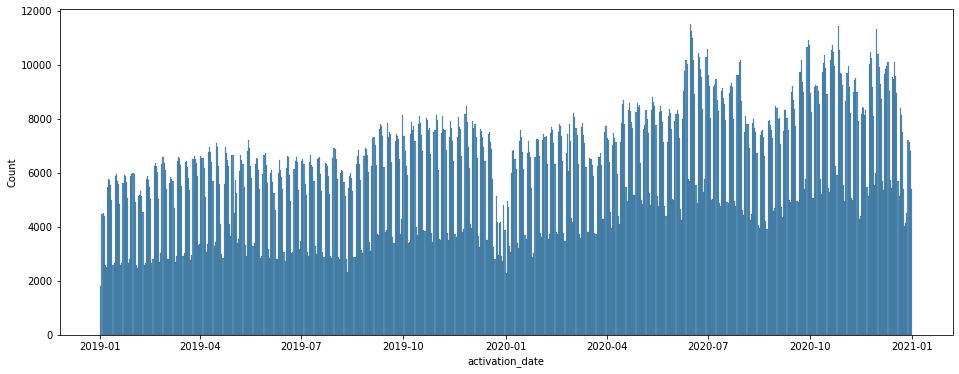

In [121]:
plt.figure(figsize=(16, 6))
ax = sns.histplot(x='activation_date', data=df[df.activation_date.dt.year.isin([2019,2020])], bins=731)

**Last update date ~ to activation date in duplicated bios**

In [122]:
df[(df.biography.notna()) &
   (df.biography.duplicated(keep=False)) &
   (df.activation_date.dt.year == df.last_update_date.dt.year) &
   (df.activation_date.dt.month == df.last_update_date.dt.month) &
   (df.activation_date.dt.day == df.last_update_date.dt.day)]

orcid  verified_email  verified_primary_email  \
591       0000-0001-6750-1481            True                    True   
17137     0000-0002-0267-4549            True                    True   
25506     0000-0001-5148-4138            True                    True   
26430     0000-0001-8210-4986            True                    True   
29059     0000-0002-1778-5209            True                    True   
...                       ...             ...                     ...   
11348461  0000-0001-9931-5843            True                    True   
11348578  0000-0003-1946-7156            True                    True   
11348981  0000-0001-9501-3717            True                    True   
11348988  0000-0003-2323-4005            True                    True   
11349108  0000-0003-4244-0381            True                    True   

           given_names      family_name  \
591          aesthetic           record   
17137     ocean impact  windows & doors   
25506            hamna              ali   
26430            oscar             hdtv   
29059           nickie          jolliff   
...                ...              ...   
11348461         lando            edgar   
11348578      mantooth           ruland   
11348981        roxann           lynsey   
11348988        ruland             star   
11349108        sumiko            cesar   

                                                  biography other_names  \
591       make your practice easy with a professional so...         NaN   
17137     address:675 nw 116th street,miami, fl 33168pho...         NaN   
25506     https://pakistanpropertyinfo.blogspot.com/2019...         NaN   
26430     https://2017-oscar.com/https://2017-oscar.com/...         NaN   
29059     presently, my favorite tv show is true detecti...         NaN   
...                                                     ...         ...   
11348461  im training to be a farm and home management a...         NaN   
11348578  i believe in living life to the fullest and fo...         NaN   
11348981  een korte inleiding op waterverwarmingstoestel...         NaN   
11348988  tentu saja semua permainan yang disediakan aka...         NaN   
11349108  welcome to my page! im still finding my way ar...         NaN   

                                                       urls primary_email  \
591       [[aesthetic record, https://www.aestheticrecor...          <NA>   
17137                                                   NaN          <NA>   
25506                                                   NaN          <NA>   
26430                                                   NaN          <NA>   
29059     [[https://www.webs.org.il, https://penzu.com/p...          <NA>   
...                                                     ...           ...   
11348461  [[tempe towing and recovery, https://brooksdhy...          <NA>   
11348578  [[wypożyczalnia samochodów cennik, https://ren...          <NA>   
11348981  [[een korte inleiding op waterverwarmingstoest...          <NA>   
11348988  [[bola88, https://sites.google.com/view/bola88...          <NA>   
11349108             [[lotterytogel, http://139.59.245.36]]          <NA>   

         keywords external_ids education employment  n_works works_source  \
591           NaN          NaN       NaN        NaN        0          NaN   
17137         NaN          NaN       NaN        NaN        0          NaN   
25506         NaN          NaN       NaN        NaN        0          NaN   
26430         NaN          NaN       NaN        NaN        0          NaN   
29059         NaN          NaN       NaN        NaN        0          NaN   
...           ...          ...       ...        ...      ...          ...   
11348461      NaN          NaN       NaN        NaN        0          NaN   
11348578      NaN          NaN       NaN        NaN        0          NaN   
11348981      NaN          NaN       NaN        NaN        0          NaN   
11348988      NaN          NaN    

Percent of dup bios accounts left inactive right after their creation

In [123]:
13663 / 19571

0.6981247764549589

**Dup bios and URLs**

In [124]:
df[(df.biography.notna()) & (df.biography.duplicated(keep=False)) & (df.urls.notna())].orcid.count()

18521

In [125]:
top_urls = dup_bios_df[['orcid', 'url_domains']]\
                .explode('url_domains')\
                .reset_index(drop=True)\
                .groupby('url_domains')\
                .count()\
                .sort_values('orcid', ascending=False)

In [126]:
set_top_n(50)
data = [
    go.Bar(
        x=top_urls[:TOP_N].index,
        y=top_urls[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='Top-%s URL domains' % TOP_N,
    xaxis=dict(tickangle=45, tickfont=dict(size=12), range=TOP_RANGE)
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

In [127]:
top_urls = df[['orcid', 'url_domains']]\
                .explode('url_domains')\
                .reset_index(drop=True)\
                .groupby('url_domains')\
                .count()\
                .sort_values('orcid', ascending=False)

In [128]:
exp = df[['orcid', 'url_domains']].explode('url_domains')

In [129]:
exp[exp.url_domains == 'lucialpiazzale.com']

orcid         url_domains
38791     0000-0001-6141-6446  lucialpiazzale.com
43120     0000-0002-5546-764X  lucialpiazzale.com
88830     0000-0001-5691-4184  lucialpiazzale.com
89955     0000-0001-7228-6456  lucialpiazzale.com
109216    0000-0002-2219-4665  lucialpiazzale.com
...                       ...                 ...
11231783  0000-0001-8141-8158  lucialpiazzale.com
11325724  0000-0002-5195-9647  lucialpiazzale.com
11327781  0000-0002-7562-5465  lucialpiazzale.com
11329297  0000-0002-8886-0069  lucialpiazzale.com
11334565  0000-0002-3054-1807  lucialpiazzale.com

[720 rows x 2 columns]

In [130]:
df[df.orcid == '0000-0002-3869-9561']

orcid  verified_email  verified_primary_email  \
144455  0000-0002-3869-9561            True                    True   

       given_names family_name  \
144455      kimble     esterly   

                                                biography other_names  \
144455  when parents tackle additional dedications out...         NaN   

                                                     urls primary_email  \
144455  [[idiaitera mathimata, http://manuelknhe509.lu...          <NA>   

       keywords external_ids education employment  n_works works_source  \
144455      NaN          NaN       NaN        NaN        0          NaN   

                        activation_date                 last_update_date  \
144455 2020-12-25 20:10:07.336000+00:00 2020-12-25 20:36:27.423000+00:00   

        n_doi  n_arxiv  n_pmc  n_other_pids other_urls  label  \
144455      0        0      0             0        NaN  False   

       primary_email_domain other_email_domains           url_domains  \
144455                  NaN                 NaN  {lucialpiazzale.com}   

       other_url_domains  n_emails  n_urls  n_ids  n_keywords  n_education  \
144455               NaN      <NA>       1   <NA>        <NA>         <NA>   

        n_employment ext_works_source  n_ext_work_source authoritative  \
144455          <NA>              NaN               <NA>         False   

        n_valid_education  n_valid_employment  biography_length  \
144455                NaN                 NaN               150   

        biography_n_sentences  biography_n_words  
144455                    1.0               25.0

Let's plot the domains which dup bios point to

In [131]:
BIO_SNIPPET = 'really cool to find an entire community of people'
dup_bios_df = df[df.biography.str.contains(BIO_SNIPPET)].explode('url_domains').groupby('url_domains')[['orcid']].count().sort_values('orcid', ascending=False)

set_top_n(50)
data = [
    go.Bar(
        x=dup_bios_df[:TOP_N].index,
        y=dup_bios_df[:TOP_N]['orcid']
    )
]

layout = go.Layout(
    title='URL distribution for bio "%s"' % BIO_SNIPPET,
    xaxis=dict(tickangle=45, tickfont=dict(size=12))
)
fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

**Assign spam score from precanned library**

In [132]:
# bios = df[df.biography.notna()][['orcid', 'biography']]

In [133]:
# def score(bio):
#     try:
#         return antispam.score(bio)
#     except: # if len(bio) < 3 the filter doesn't know how to handle that
#         return -1

In [134]:
# bios['spam_score'] = bios.biography.apply(lambda bio: score(bio))

In [135]:
# bios[bios.spam_score == -1] # these are artefacts (no scoring possible)

In [136]:
# bios.spam_score.replace(to_replace=-1, value=np.nan, inplace=True)

In [137]:
# bios.spam_score.describe()

In [138]:
# bios[bios.spam_score > 0.99]

Spam goes nowhere.

**Search offending words, sexually explicit content, etc.**

In [139]:
# bios['profanity_score'] = profanity_check.predict_prob(bios.biography)

In [140]:
# bios[bios.profanity_score > 0.90]

Profanity detection goes nowhere too.

## Dates

In [141]:
df[df.activation_date == df.last_update_date]['orcid'].count()

118109

In [142]:
df[df.activation_date > df.last_update_date]['orcid'].count()

146706

In [143]:
df[(df.activation_date.dt.year == df.last_update_date.dt.year) &
   (df.activation_date.dt.month == df.last_update_date.dt.month) &
   (df.activation_date.dt.day == df.last_update_date.dt.day)]['orcid'].count()

3583463

In [144]:
df['date_diff'] = (df.last_update_date - df.activation_date) / np.timedelta64(1, 'D')
df.date_diff.describe()

count    1.134961e+07
mean     5.686668e+02
std      7.509238e+02
min     -9.120370e-06
25%      1.042343e-02
50%      1.923021e+02
75%      9.453061e+02
max      3.128712e+03
Name: date_diff, dtype: float64

In [145]:
df[df.date_diff == df.date_diff.min()]

orcid  verified_email  verified_primary_email  \
11125024  0000-0002-4035-0449           False                   False   

         given_names  family_name biography other_names urls primary_email  \
11125024    aracelis  fiffe pérez      <NA>         NaN  NaN          <NA>   

         keywords external_ids education employment  n_works works_source  \
11125024      NaN          NaN       NaN        NaN        0          NaN   

                          activation_date                 last_update_date  \
11125024 2020-08-04 14:18:03.177000+00:00 2020-08-04 14:18:02.389000+00:00   

          n_doi  n_arxiv  n_pmc  n_other_pids other_urls  label  \
11125024      0        0      0             0        NaN  False   

         primary_email_domain other_email_domains url_domains  \
11125024                  NaN                 NaN         NaN   

         other_url_domains  n_emails  n_urls  n_ids  n_keywords  n_education  \
11125024               NaN      <NA>    <NA>   <NA>        <NA>         <NA>   

          n_employment ext_works_source  n_ext_work_source authoritative  \
11125024          <NA>              NaN               <NA>         False   

          n_valid_education  n_valid_employment  biography_length  \
11125024                NaN                 NaN              <NA>   

          biography_n_sentences  biography_n_words  date_diff  
11125024                    NaN                NaN  -0.000009

In [146]:
df.loc[df.date_diff < 0, 'date_diff'] = 0

In [147]:
# df['ref_year'] = df.activation_date.dt.year

In [148]:
# fig = go.Figure()
# years = range(2013, 2021, 1)

# for year in years:
#     fig.add_trace(go.Violin(x=df[df.ref_year == year].ref_year,
#                             y=df[df.ref_year == year].date_diff,
#                             name=year,
#                             points=False,
#                             box_visible=True,
#                             meanline_visible=True))

# fig.show()

In [149]:
# plt.figure(figsize=(16, 6))
# ax = sns.violinplot(x='ref_year', y='date_diff', data=df)

In [150]:
# df['ref_year'] = df.last_update_date.dt.year

# plt.figure(figsize=(16, 6))
# ax = sns.violinplot(x='ref_year', y='date_diff', data=df)

In [151]:
# tz = pytz.timezone('UTC')
# NOW = datetime.now(tz)

# df['date_stale'] = (NOW - df.last_update_date) / np.timedelta64(1, 'D')
# df.date_stale.describe()

In [152]:
# plt.figure(figsize=(16, 6))
# ax= sns.violinplot(x='ref_year', y='date_stale', data=df)

In [153]:
# df['ref_year'] = df.activation_date.dt.year

# plt.figure(figsize=(16, 6))
# ax = sns.violinplot(x='ref_year', y='date_stale', data=df)

Todo:
- stale profiles with information initially set are likely to be fake?
- the more info is visible, the higher the chance the profile is fake if not updated (for long)? 

# All VS all colleration

In [154]:
fig = px.imshow(df.select_dtypes(include=['bool','number']).fillna(-1).corr())
fig.show()

In [155]:
# df.select_dtypes(include=['bool','number']).to_pickle('../data/processed/features.pkl')

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11349607 entries, 0 to 11349606
Data columns (total 42 columns):
 #   Column                  Dtype              
---  ------                  -----              
 0   orcid                   object             
 1   verified_email          bool               
 2   verified_primary_email  bool               
 3   given_names             string             
 4   family_name             string             
 5   biography               string             
 6   other_names             object             
 7   urls                    object             
 8   primary_email           string             
 9   keywords                object             
 10  external_ids            object             
 11  education               object             
 12  employment              object             
 13  n_works                 Int16              
 14  works_source            object             
 15  activation_date         datetime64[ns, UTC]
 16

In [157]:
# df[df.orcid.isin(FAKE_HEAP.values())].to_csv('../data/processed/fake_heap_index.csv', index=True, index_label='index')

## Filtering

In [158]:
df[(df.url_domains.notna()) | (df.other_url_domains.notna())][['orcid', 'given_names', 'family_name', 'other_names', 'url_domains', 'other_url_domains', 'activation_date', 'last_update_date']]

orcid         given_names       family_name  \
5         0000-0001-7402-0096                <NA>              <NA>   
10        0000-0001-8377-3508                <NA>              <NA>   
26        0000-0002-2638-4108                <NA>              <NA>   
151       0000-0003-1284-9741  alex percy antonio  manriquez paisig   
171       0000-0001-7324-3247              amable     lopez piñeiro   
...                       ...                 ...               ...   
11349581  0000-0002-7878-164X             mostafa           metwaly   
11349582  0000-0001-9322-3665            muhammed          abdallah   
11349589  0000-0002-5204-5302               sabri          alshboul   
11349597  0000-0002-2906-0299             tiffany            mackay   
11349599  0000-0002-1070-2220            vinicios          santanna   

                                                other_names  \
5                                                       NaN   
10                               [fontana, milena da silva]   
26                                                      NaN   
151                                                     NaN   
171                                                     NaN   
...                                                     ...   
11349581                                  [mostafa metwaly]   
11349582                                                NaN   
11349589                                                NaN   
11349597                               [tiffany russel sia]   
11349599  [vinicios sant anna, vinicios sant anna, vinic...   

                                url_domains other_url_domains  \
5                                  {kth.se}               NaN   
10                                {cnpq.br}               NaN   
26                           {unioviedo.es}               NaN   
151                           {youtube.com}               NaN   
171                                {upm.es}               NaN   
...                                     ...               ...   
11349581  {researchgate.net, google.com.eg}               NaN   
11349582                     {linkedin.com}               NaN   
11349589         {apetau.com, facebook.com}               NaN   
11349597    {oxytocin.com.au, linkedin.com}               NaN   
11349599                   {vpsantanna.com}               NaN   

                          activation_date                 last_update_date  
5        2015-01-11 15:13:06.467000+00:00 2016-06-14 23:55:59.896000+00:00  
10       2018-05-23 23:39:04.534000+00:00 2019-10-16 02:50:11.007000+00:00  
26       2013-03-25 14:38:06.016000+00:00 2020-07-01 13:10:37.025000+00:00  
151      2020-09-08 20:04:33.906000+00:00 2020-09-08 20:25:55.432000+00:00  
171      2014-12-19 11:48:29.669000+00:00 2019-12-09 18:48:42.579000+00:00  
...                                   ...                              ...  
11349581 2019-02-20 15:42:51.321000+00:00 2020-12-10 08:41:24.931000+00:00  
11349582 2020-03-08 08:45:25.890000+00:00 2020-12-11 14:00:24.149000+00:00  
11349589 2016-12-10 09:09:48.405000+00:00 2020-11-28 18:51:42.007000+00:00  
11349597 2017-01-03 23:28:48.736000+00:00 2020-12-09 17:12:20.326000+00:00  
11349599 2016-03-19 21:24:42.821000+00:00 2020-12-10 16:34:09.722000+00:00  

[755856 rows x 8 columns]